In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import joblib 

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn.metrics import r2_score as r2

In [5]:
from sklearn.model_selection import GridSearchCV

In [37]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [6]:
Df_r = pd.read_csv('registros_autos.csv',parse_dates = ['Fecha'])
Df_r.head()

,Fecha,Unidades
0,2012-01-01,0
1,2012-02-01,188
2,2012-03-01,482
3,2012-04-01,927
4,2012-05-01,1159


In [7]:
Df_r.isna().sum()

Fecha       0
Unidades    0
dtype: int64

In [8]:
Df_festivos = pd.read_csv('festivos.csv',parse_dates = ['Fecha'])
Df_festivos.head()

,Fecha
0,2012-01-01
1,2012-09-01
2,2012-03-19
3,2012-01-04
4,2012-05-04


In [9]:
Df_r['Festivo'] = Df_r['Fecha'].apply(lambda x : 1 if x in Df_festivos['Fecha'].unique() else 0)

In [10]:
Df_r.head()

,Fecha,Unidades,Festivo
0,2012-01-01,0,1
1,2012-02-01,188,0
2,2012-03-01,482,0
3,2012-04-01,927,0
4,2012-05-01,1159,0


In [11]:
Df_r['Year']= pd.DatetimeIndex(Df_r['Fecha']).year
Df_r['Month']= pd.DatetimeIndex(Df_r['Fecha']).month
Df_r['Day']= pd.DatetimeIndex(Df_r['Fecha']).day
Df_r['Dayweek'] = Df_r['Fecha'].dt.day_name()

In [12]:
Df_r.head()

,Fecha,Unidades,Festivo,Year,Month,Day,Dayweek
0,2012-01-01,0,1,2012,1,1,Sunday
1,2012-02-01,188,0,2012,2,1,Wednesday
2,2012-03-01,482,0,2012,3,1,Thursday
3,2012-04-01,927,0,2012,4,1,Sunday
4,2012-05-01,1159,0,2012,5,1,Tuesday


In [13]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
DF1 = Df_r.groupby(['Dayweek','Year'])[['Unidades']].sum().unstack().reindex(cats)
DF1

Unidades                                   
Year          2012   2013   2014   2015   2016   2017
Dayweek                                              
Monday       44276  37616  42014  37164  34990  27893
Tuesday      46925  50763  56854  48594  43770  42522
Wednesday    54083  52503  57666  53424  46762  46425
Thursday     59663  57737  58355  50837  51146  44724
Friday       63356  52751  68788  54680  44414  47241
Saturday     28361  29323  28354  25794  21075  18814
Sunday       15256  15110  15447  14423  12736  11878

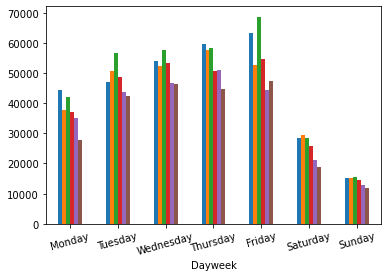

In [14]:
ax = DF1.plot.bar(rot=15.5, legend = False)
plt.savefig('days.jpg', dpi = 100)
#plt.xticks(rotation='82.5')

In [15]:
DF2 = Df_r.groupby(['Month','Year'])['Unidades'].sum().unstack()
DF2

Year,2012,2013,2014,2015,2016,2017
Month,,,,,,
1,21071,20202,22786,20685,19262,17464
2,23696,20438,21232,19450,18280,16225
3,29131,20538,24253,22921,17226,19617
4,25150,24377,24096,24822,20365,15994
5,25113,26788,29135,23592,19961,18915
6,26592,25200,22926,22011,21158,21392
7,25555,23255,27106,25791,19542,20311
8,26089,25484,27809,22412,21478,20169
9,25655,25103,26403,25102,21884,19755


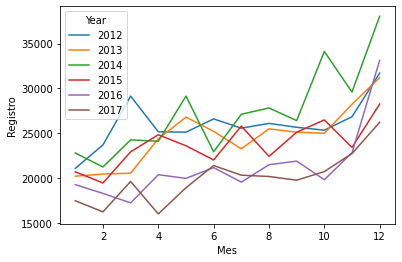

In [16]:
ax2= DF2.plot.line()
plt.ylabel("Registro")
plt.xlabel("Mes")
plt.savefig('tenden.jpg', dpi = 400)

In [17]:
namemonth = {1 : 'Jan', 2:'Feb',3:'Mar', 4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

In [18]:
Vacaciones = [1,6,7,11,12]

In [19]:
Df_r['NamMonth'] = Df_r['Month'].apply(lambda x: namemonth[x])
Df_r['Holidays'] = Df_r['Month'].apply(lambda x: 1 if x in Vacaciones else 0)

In [20]:
Df_r = Df_r[['Year','Month','Day','Dayweek','Festivo','Holidays','Unidades']]

In [21]:
Df_r.head()

,Year,Month,Day,Dayweek,Festivo,Holidays,Unidades
0,2012,1,1,Sunday,1,1,0
1,2012,2,1,Wednesday,0,0,188
2,2012,3,1,Thursday,0,0,482
3,2012,4,1,Sunday,0,0,927
4,2012,5,1,Tuesday,0,0,1159


In [22]:
Df_rTr = Df_r[Df_r['Year']<2017]
Df_rTes = Df_r[Df_r['Year']>=2017]

In [23]:
Df_rTes.reset_index(inplace = True)
Df_rTr.reset_index(inplace =  True)

In [24]:
Df_rTes = Df_rTes.drop(['index'], axis = 1)
Df_rTr = Df_rTr.drop(['index'], axis = 1)

In [25]:
Df_rTr.head()

,Year,Month,Day,Dayweek,Festivo,Holidays,Unidades
0,2012,1,1,Sunday,1,1,0
1,2012,2,1,Wednesday,0,0,188
2,2012,3,1,Thursday,0,0,482
3,2012,4,1,Sunday,0,0,927
4,2012,5,1,Tuesday,0,0,1159


## One hot encoding

In [26]:
Df_rTr = pd.get_dummies(Df_rTr)
Df_rTes = pd.get_dummies(Df_rTes)

In [23]:
#Df_rTes.reset_index(inplace = True)
#Df_rTr.reset_index(inplace =  True)

In [27]:
Df_rTr.head()

,Year,Month,Day,Festivo,Holidays,Unidades,Dayweek_Friday,Dayweek_Monday,Dayweek_Saturday,Dayweek_Sunday,Dayweek_Thursday,Dayweek_Tuesday,Dayweek_Wednesday
0,2012,1,1,1,1,0,0,0,0,1,0,0,0
1,2012,2,1,0,0,188,0,0,0,0,0,0,1
2,2012,3,1,0,0,482,0,0,0,0,1,0,0
3,2012,4,1,0,0,927,0,0,0,1,0,0,0
4,2012,5,1,0,0,1159,0,0,0,0,0,1,0


In [25]:
Df_rTes.to_csv('Data_test.csv', index = False, encoding = 'utf-8')

In [28]:
num = list(Df_rTr.columns.values)
num.remove('Unidades')

In [29]:
num

['Year',
 'Month',
 'Day',
 'Festivo',
 'Holidays',
 'Dayweek_Friday',
 'Dayweek_Monday',
 'Dayweek_Saturday',
 'Dayweek_Sunday',
 'Dayweek_Thursday',
 'Dayweek_Tuesday',
 'Dayweek_Wednesday']

### Evaluación del modelo

In [28]:
exp_reg101 = setup(data = Df_rTr, target = 'Unidades', numeric_features = num , normalize = True, session_id = 2112)

,Description,Value
0,session_id,2112
1,Target,Unidades
2,Original Data,"(1827, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1278, 12)"


In [29]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,232.4887,108628.7903,328.6738,0.6273,2.0476,18.3177,0.0910
rf,Random Forest Regressor,217.0955,109592.0459,329.8930,0.6243,1.5899,16.0336,0.3870
et,Extra Trees Regressor,216.2471,111399.2027,332.8190,0.6172,1.6066,15.9479,0.4150
catboost,CatBoost Regressor,222.3145,113104.6133,335.0983,0.6120,1.9973,16.7382,0.6620
lightgbm,Light Gradient Boosting Machine,230.8407,122414.7655,348.6317,0.5798,1.8973,19.0240,0.5860
knn,K Neighbors Regressor,250.6688,134537.5258,365.9761,0.5370,1.7045,16.2441,0.0250
xgboost,Extreme Gradient Boosting,240.7535,137931.2117,370.1601,0.5271,1.9946,18.3522,0.2590
br,Bayesian Ridge,300.9232,166138.7439,407.3040,0.4282,2.3509,24.1658,0.0230
lasso,Lasso Regression,300.6387,166143.1078,407.3118,0.4282,2.3482,24.1119,0.0200
ridge,Ridge Regression,300.3736,166149.3406,407.3199,0.4281,2.3501,24.0883,0.0220


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2112, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
rfi = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,222.9130,110659.7818,332.6557,0.5559,1.1541,12.4227
1,226.5761,120566.0109,347.2262,0.5748,1.6738,29.5445
2,182.4112,89184.6276,298.6380,0.6766,1.4620,20.6010
3,256.1778,146837.9590,383.1944,0.5684,1.8073,10.2460
4,222.4098,120894.0157,347.6982,0.6001,1.6093,15.0194
5,181.1354,75746.9866,275.2217,0.7323,1.3745,7.2373
6,219.3590,115240.8784,339.4715,0.6093,1.8937,19.5495
7,218.5045,105345.3333,324.5695,0.6690,1.3959,13.1543
8,226.2209,108199.5373,328.9370,0.5899,1.6520,13.0424
9,215.2472,103245.3288,321.3181,0.6663,1.8760,19.5193


### Sintonización de parámetros

In [30]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3500, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [2,5,7,9,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]


In [31]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
rf_random4 = RandomizedSearchCV(estimator = rfi, param_distributions = random_grid, 
                               n_iter = 200, cv = 5, verbose=2, n_jobs = -1)
rf_random4.fit(Df_rTr[num], Df_rTr['Unidades'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 69.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [35]:
rf_random5 = RandomizedSearchCV(estimator = rfi, param_distributions = random_grid, 
                               n_iter = 350, cv = 5, verbose=2, n_jobs = -1)
rf_random5.fit(Df_rTr[num], Df_rTr['Unidades'])

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 76.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 110.7min
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed: 132.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [46]:
#rf = RandomForestRegressor(n_estimators= 1600,min_samples_split= 5,min_samples_leaf= 1,max_features= 'auto',
# max_depth= 10, bootstrap= True)
rf = rf_random4.best_estimator_

In [47]:
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1666, n_jobs=-1, oob_score=False,
                      random_state=2112, verbose=0, warm_start=False)

### Evaluación del modelo para cojunto de entrenamiento

In [53]:
rfit = rf.fit(Df_rTr[num],Df_rTr['Unidades'])

In [31]:
pred = rfit.predict(Df_rTr[num])

In [40]:
pred

array([ 139.74836157,  404.23071696,  556.72896436, ..., 2350.69472173,
       2222.53963655,  615.72001342])

In [32]:
round (r2(Df_rTr['Unidades'],pred),2)*100

78.0

## Evaluación del modelo para cojunto de prueba

In [33]:
predtest = rfit.predict(Df_rTes[num])

In [34]:
round (r2(Df_rTes['Unidades'],predtest),2)*100

70.0

In [35]:
residual = Df_rTes['Unidades'] - predtest

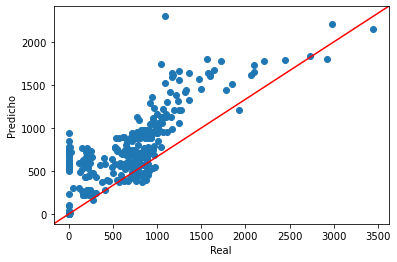

In [39]:
fig, ax = plt.subplots()
line = mlines.Line2D([0, 1], [0, 1], color='red')
ax.scatter(Df_rTes['Unidades'],predtest)
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
#plt.title("title")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.savefig('scatter.png', dpi = 400)
plt.show()

## Modelo guardado 

In [58]:
#joblib.dump(rfit, 'modelo_runt_entrenado.pkl') # Se guarda el modelo.

['modelo_runt_entrenado.pkl']